# Catboost Model

There are a few different options I could've chosen for the model, and in a real-world scenario I would test many different ones. My choice for Catboost is based on a few different things:

1. I have experience with it.
2. It has a great set of default parameters that produce good results - in a real-world scenario I would spend more time tuning hyperparameters, but I want to keep this analysis simple.
3. It has some useful plotting functions which can show use what the most important features are.

In [ ]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
import shap

# autoreload
%load_ext autoreload
%autoreload 2

In [5]:
# Load training and test data pickle
train_cleaned = pd.read_pickle("../data/cleaned/train.pkl")
test_cleaned = pd.read_pickle("../data/cleaned/test.pkl")

In [6]:
CAT_FEATURES = [
    "occupation",
    "payment_of_min_amount",
    "payment_behaviour"
]

# Set up training and test pools
train_pool = Pool(
    data=train_cleaned.drop(columns=["credit_score_target"]),
    label=train_cleaned["credit_score_target"],
    cat_features=CAT_FEATURES
)

test_pool = Pool(
    data=test_cleaned.drop(columns=["credit_score_target"]),
    label=test_cleaned["credit_score_target"],
    cat_features=CAT_FEATURES
)

# Initialize CatBoostRegressor
catboost_regressor = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=100,
    one_hot_max_size=20,
)

# Fit the model
catboost_regressor.fit(train_pool)

0:	learn: 25.4037735	total: 67.6ms	remaining: 1m 7s
100:	learn: 13.3945448	total: 530ms	remaining: 4.72s
200:	learn: 13.0605894	total: 919ms	remaining: 3.65s
300:	learn: 12.8522901	total: 1.32s	remaining: 3.07s
400:	learn: 12.6884438	total: 1.8s	remaining: 2.69s
500:	learn: 12.5406169	total: 2.23s	remaining: 2.22s
600:	learn: 12.4038409	total: 2.66s	remaining: 1.77s
700:	learn: 12.2858042	total: 3.07s	remaining: 1.31s
800:	learn: 12.1734618	total: 3.49s	remaining: 866ms
900:	learn: 12.0682904	total: 3.88s	remaining: 427ms
999:	learn: 11.9675404	total: 4.29s	remaining: 0us


In [7]:
# Print hyperparameters of catboost_regressor
print(catboost_regressor.get_params())

{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'RMSE', 'verbose': 100, 'one_hot_max_size': 20}


In [8]:
# Calculate feature statistics
catboost_regressor.calc_feature_statistics(train_pool, max_cat_features_on_plot=20);

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

# Make predictions on the test set
y_pred = catboost_regressor.predict(test_pool)
y_test = test_pool.get_label()

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 11.418499141584894
MSE: 225.02104095156864
RMSE: 15.000701348655957


In [37]:
# Calculate feature statistics
feature_importances = catboost_regressor.get_feature_importance(train_pool, prettified=True, type="ShapValues")
feature_importances.columns = train_cleaned.columns
feature_importances.sum(axis=0).sort_values(ascending=False)

credit_score_target         7.014920e+07
payment_of_min_amount       1.931787e+04
annual_income               1.913887e+04
interest_rate               1.057436e+04
delay_from_due_date         5.669818e+03
monthly_inhand_salary       4.048809e+03
num_of_delayed_payment      3.836872e+03
amount_invested_monthly     2.666113e+03
payment_behaviour           1.927434e+03
num_credit_card             1.801467e+03
num_credit_inquiries        1.686752e+03
Debt Consolidation Loan     6.691692e+02
total_emi_per_month         4.723996e+02
Not Specified               3.790285e+02
Student Loan                3.368416e+02
changed_credit_limit        3.333285e+02
Auto Loan                   2.261966e+02
occupation                  2.159388e+02
Mortgage Loan               2.034110e+02
Payday Loan                 5.400220e+01
Personal Loan              -3.728474e+01
Credit-Builder Loan        -9.556477e+01
Home Equity Loan           -1.510758e+02
credit_utilization_ratio   -3.926067e+02
age             

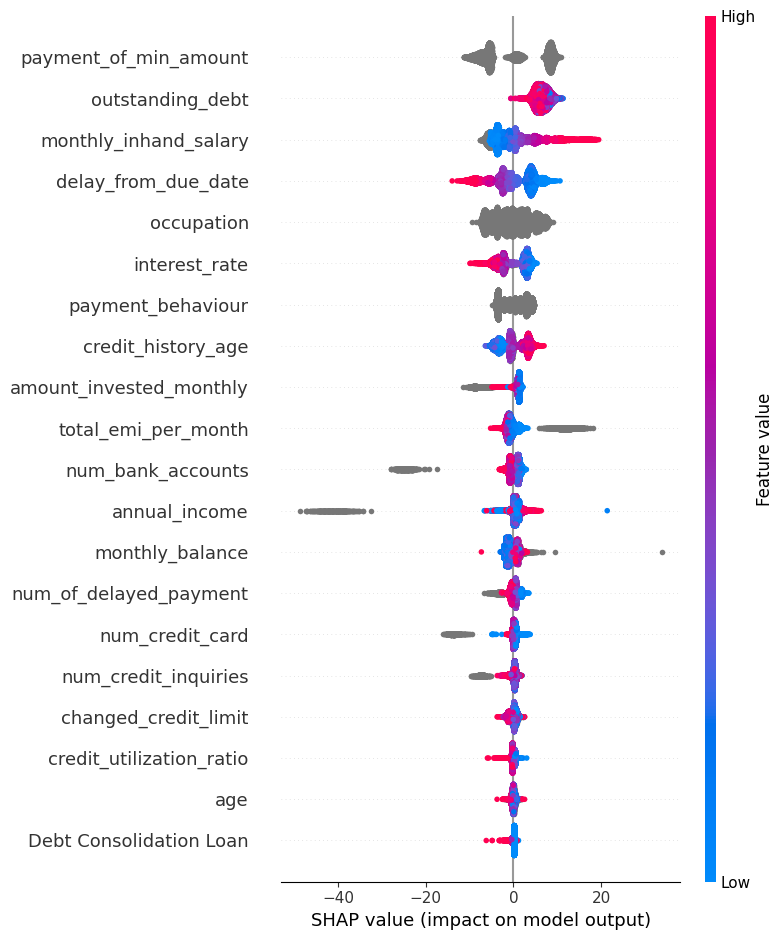

In [82]:
# Calculate SHAP values
from shap import TreeExplainer

explainer = TreeExplainer(catboost_regressor)
explanation = explainer(test_cleaned.drop(columns=["credit_score_target"]))

# Get SHAP values
shap_values = explanation.values

# Plot SHAP summary plot
shap.summary_plot(shap_values, test_cleaned.drop(columns=["credit_score_target"]), feature_names=test_pool.get_feature_names())

In [83]:
# Select a single prediction to explain
shap.initjs()

index_to_explain = 0
single_prediction = shap_values[index_to_explain]

# Plot SHAP force plot for the single prediction
shap.force_plot(
    explainer.expected_value,
    single_prediction,
    test_cleaned.drop(columns=["credit_score_target"]).iloc[index_to_explain],
    feature_names=train_pool.get_feature_names()
)

In [84]:
validation_cleaned = pd.read_pickle("../data/cleaned/validation.pkl")
validation_pool = Pool(validation_cleaned, cat_features=CAT_FEATURES)
validation_cleaned.head()

,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,...,monthly_balance,Not Specified,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
0,40.0,Mechanic,33749.25,2640.437500,5.0,7.0,3.0,20,13.0,4.16,...,299.928737,0,0,0,0,0,0,0,0,2
1,20.0,Lawyer,49460.16,4270.680000,9.0,6.0,18.0,58,14.0,16.82,...,241.121601,1,1,0,2,1,0,0,0,0
2,43.0,Lawyer,108129.44,8776.786667,4.0,3.0,8.0,7,8.0,19.70,...,789.253530,0,1,1,0,0,0,0,0,0
3,43.0,Manager,124564.60,10207.383333,3.0,4.0,6.0,8,16.0,11.63,...,428.326432,0,2,0,1,0,1,0,2,1
4,35.0,Lawyer,45705.78,3866.815000,8.0,3.0,20.0,9,8.0,9.97,...,255.930733,0,0,0,0,0,0,0,0,0


In [85]:
validation__preds = catboost_regressor.predict(validation_pool)
validation_shap = catboost_regressor.get_feature_importance(validation_pool, type='ShapValues')[:, :-1]

In [86]:
def explain_prediction(X, shap_values, index):
    shap.initjs()
    return shap.force_plot(
        explainer.expected_value,
        shap_values[index],
        X.iloc[index],
        feature_names=X.columns
    )

In [87]:
explain_prediction(validation_cleaned, validation_shap, 0)

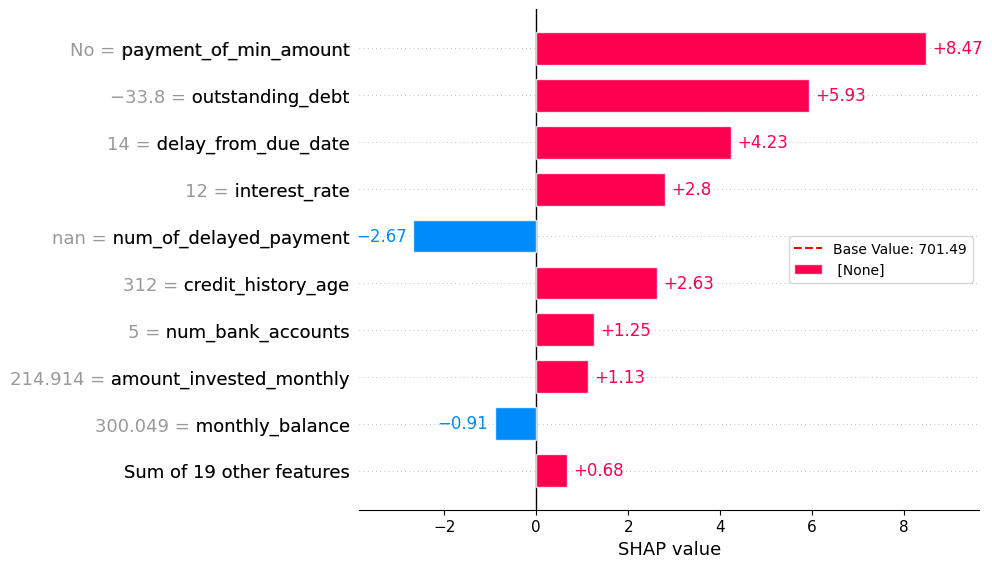

In [106]:
import matplotlib.pyplot as plt

base_value = explanation[0].base_values
shap.plots.bar(explanation[0], show=False)

plt.axvline(x=base_value, color='red', linestyle='--', label=f"Base Value: {base_value:.2f}")
plt.legend()
plt.show()

In [100]:
int(explanation[0].base_values + explanation[0].values.sum())

725

In [101]:
int(y_pred[0])

725